## INTRODUCTION AND PLAN

### INTRODUCTION

In this project, we use transfer learning to classify images of natural scenes, using the Intel Image Classification dataset. Our main goal is to fine-tune a pretrained vision model, compare it to a basic CNN built from scratch, and use Grad-CAM visualizations to explain how the models make decisions.

### DATASET CHOICE

We chose Intel Natural Scenes dataset, which contains approximately 25000 images of natural scenes around the world. All images are 150x150 pixels in RGB format, distributed across 6 scene categories: Buildings, Forest, Glacier, Mountain, Sea, and Street.

 **Key Challenge**

Some categories overlap (like mountains and glaciers, or streets and buildings), so the model must learn subtle differences instead of relying on obvious clues.

**Data Split**

- Training set: ~14000 images
- Test set: ~3000 images
- Prediction set: ~7000 images (unlabeled)

**We chose the Intel Natural Scenes dataset because:**

- It presents real-world challenges, like overlapping categories and variety within each class
- Pretrained ImageNet features are highly relevant for this data
- The size (14000+ images) is ideal for demonstrating transfer learning -> large enough for fine-tuning, small enough to see effects of different settings
- It creates interesting cases for Grad-CAM analysis, especially where categories are easily confused

### PREPROCESSING

1. **Resize** images from 150x150 to 224x224 pixels, matching what pretrained models expect
2. **Normalize** using ImageNet statistics to ensure compatibility with pretrained weights, using other values would hurt performance
3. **Data Augmentation for Training:**
    - Horizontal flips (images are naturally symmetric)
    - Small rotations (+/-15°) to mimic camera tilt
    - Color adjustments for brightness, contrast, and hue to simulate different lighting
    - Random crops to mimic zoom changes
4. **No augmentation** for validation or test data to keep results fair

### Model Selection

ResNet-50 (a 50-layer neural network pretrained on ImageNet)

**Why this model?**
- Deep enough to learn complex features, but not so large it overfits
- Well-studied, with results we can compare to published work
- Its structure is ideal for Grad-CAM interpretation

**Why not other models?**
- Smaller ResNets: Not enough capacity for subtle scene differences
- Larger ResNets and VGG: Too big, risk overfitting, slow to train
- EfficientNet/ViT: More complex or require larger datasets
- MobileNet: Designed for mobile, less accurate for this task

### HYPERPARAMETER TUNING

We’ll test three learning rates for fine-tuning: 0.0001, 0.0005, 0.001

Learning rate is one of the most important setting affecting both speed and accuracy. Lower rates may underfit, higher rates risk overfitting.

### EVALUATION METRICS

1. Overall accuracy (main metric, since classes are balanced)
2. Per-class accuracy (to spot which scenes are harder)
3. Confusion matrix (to see which categories are most often confused)
4. Precision, recall, and F1-score for each class
5. Training curves (to visualize learning and spot overfitting)

## DATA EXPLORATION AND PREPROCESSING

### EDA

**Basic Overview**

We start by loading the dataset and identifying the different scene categories. This step helps us get a clear overview of what classes we’ll be working with throughout the project

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import Counter
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Dataset paths
train_dir = 'dataset/seg_train/seg_train'
test_dir = 'dataset/seg_test/seg_test'

# Class names
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
num_classes = len(class_names)

print(f"Dataset: Intel Natural Scenes")
print(f"Classes: {class_names}")
print(f"Number of classes: {num_classes}")

Dataset: Intel Natural Scenes
Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Number of classes: 6


Next, we gather all the image file paths and their corresponding labels for both the training and test sets. This gives us a structured way to access each image and its class, which will make data handling much easier as we move forward.

In [2]:
def load_dataset(data_dir):
    image_paths = []
    labels = []

    for class_idx, class_name in enumerate(class_names):
        class_path = os.path.join(data_dir, class_name)
        if os.path.exists(class_path):
            for img_file in os.listdir(class_path):
                if img_file.endswith(('.jpg', '.jpeg', '.png')):
                    image_paths.append(os.path.join(class_path, img_file))
                    labels.append(class_idx)

    return image_paths, labels

# Load data
train_paths, train_labels = load_dataset(train_dir)
test_paths, test_labels = load_dataset(test_dir)

print(f"\nTraining images: {len(train_paths)}")
print(f"Test images: {len(test_paths)}")


Training images: 14034
Test images: 3000


**Class Balance**

Now we check how many images there are for each scene category in both the training and test sets. Making sure the dataset is balanced across classes is important, if some categories have a lot more images than others, the model could become biased. This step helps us spot any imbalance early so we can address it if needed.


=== CLASS DISTRIBUTION ===

Training set:
  buildings : 2191 (15.6%)
  forest    : 2271 (16.2%)
  glacier   : 2404 (17.1%)
  mountain  : 2512 (17.9%)
  sea       : 2274 (16.2%)
  street    : 2382 (17.0%)

Test set:
  buildings :  437 (14.6%)
  forest    :  474 (15.8%)
  glacier   :  553 (18.4%)
  mountain  :  525 (17.5%)
  sea       :  510 (17.0%)
  street    :  501 (16.7%)


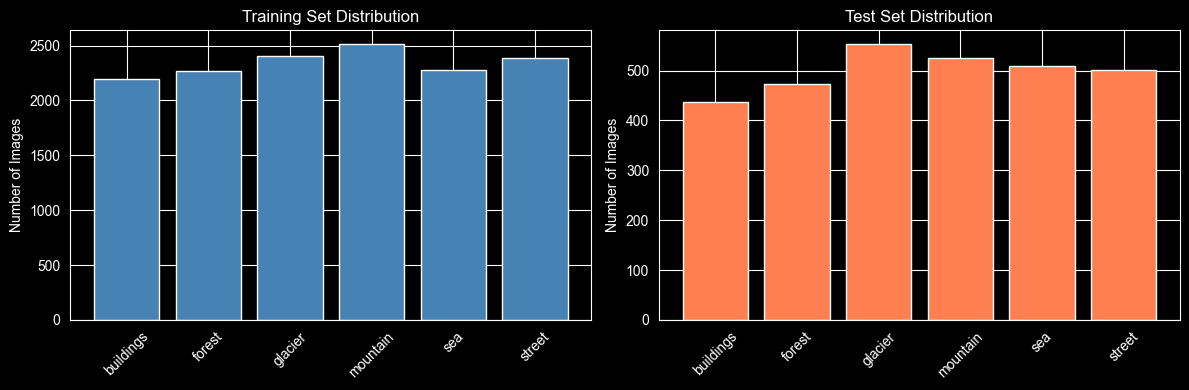


Balance ratio: 0.872
Dataset is well balanced - no special handling needed


In [3]:
train_counts = Counter(train_labels)
test_counts = Counter(test_labels)

print("\n=== CLASS DISTRIBUTION ===\n")
print("Training set:")
for i, name in enumerate(class_names):
    count = train_counts[i]
    percent = (count / len(train_labels)) * 100
    print(f"  {name:10s}: {count:4d} ({percent:.1f}%)")

print(f"\nTest set:")
for i, name in enumerate(class_names):
    count = test_counts[i]
    percent = (count / len(test_labels)) * 100
    print(f"  {name:10s}: {count:4d} ({percent:.1f}%)")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Visualize
axes[0].bar(class_names, [train_counts[i] for i in range(num_classes)], color='steelblue')
axes[0].set_title('Training Set Distribution')
axes[0].set_ylabel('Number of Images')
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(class_names, [test_counts[i] for i in range(num_classes)], color='coral')
axes[1].set_title('Test Set Distribution')
axes[1].set_ylabel('Number of Images')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Check balance
balance_ratio = min(train_counts.values()) / max(train_counts.values())
print(f"\nBalance ratio: {balance_ratio:.3f}")
if balance_ratio > 0.85:
    print("Dataset is well balanced - no special handling needed")
else:
    print("Dataset is imbalanced - may need class weights")

 Classes are balanced (each has roughly equal samples), so we can use accuracy as our main metric and don't need techniques like SMOTE or class weighting.

**Consistent Sizing**

Here we take all training images to check their dimensions. Knowing whether all images are the same size (or if there’s variation) helps us plan our preprocessing steps. Consistent image sizes simplify model training, while different sizes mean we’ll need to standardize them before feeding them into the network.

In [4]:
widths, heights = [], []
for path in train_paths:
    img = Image.open(path)
    w, h = img.size
    widths.append(w)
    heights.append(h)

print(f"\n=== IMAGE DIMENSIONS ===\n")
print(f"Checked {len(widths)} images:")
print(f"Width:  {min(widths)} - {max(widths)} (median: {int(np.median(widths))})")
print(f"Height: {min(heights)} - {max(heights)} (median: {int(np.median(heights))})")

if len(set(zip(widths, heights))) == 1:
    print(f"All images are {widths[0]}×{heights[0]} (uniform size)")
else:
    print(f"Various image sizes detected")
    # most common sizes
    from collections import Counter
    size_counts = Counter(zip(widths, heights))
    print()
    print(f"Most common sizes:")
    for (w, h), count in size_counts.most_common(5):
        print(f"  {w}x{h}: {count} images ({count/len(widths)*100:.1f}%)")


=== IMAGE DIMENSIONS ===

Checked 14034 images:
Width:  150 - 150 (median: 150)
Height: 76 - 150 (median: 150)
Various image sizes detected

Most common sizes:
  150x150: 13986 images (99.7%)
  150x113: 7 images (0.0%)
  150x135: 3 images (0.0%)
  150x111: 3 images (0.0%)
  150x108: 2 images (0.0%)


Most images are 150x150, but some have different heights (ranging from 76-150). This variation doesn't matter because our Resize((224, 224)) transform will standardize all images to 224x224 regardless of their original aspect ratio. The resize operation handles this automatically by stretching/compressing as needed.

**Sample Images**

Here we display a selection of images from every category in the training set. Reviewing sample images allows us to quickly assess the diversity and quality of our data, and ensures that each class is represented as expected.


=== SAMPLE VISUALIZATION ===



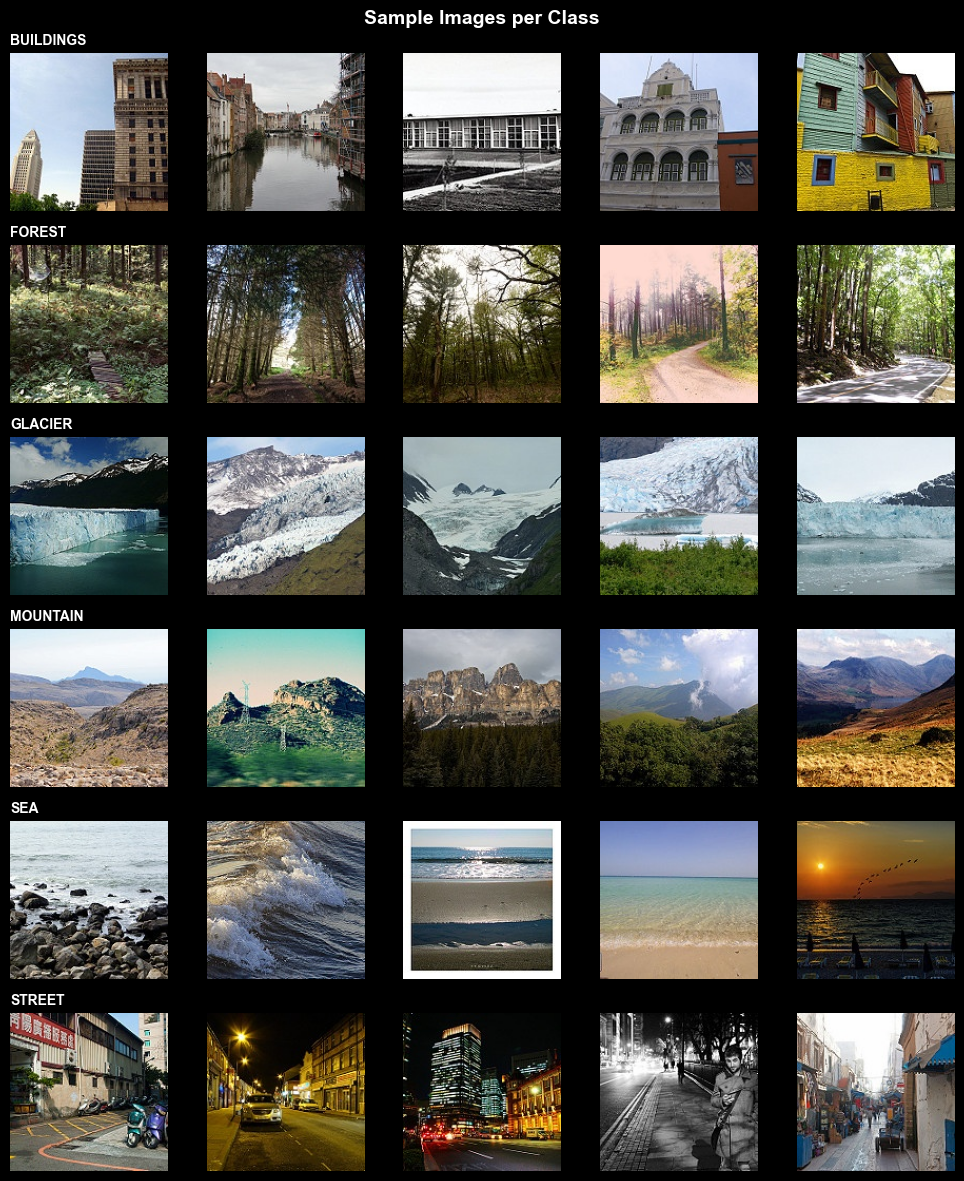

In [5]:
def show_samples(paths, labels, samples_per_class=3):
    """Display sample images from each class."""
    fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(10, 12))

    for class_idx in range(num_classes):
        # Get images from this class
        class_paths = [p for p, l in zip(paths, labels) if l == class_idx]
        samples = np.random.choice(class_paths, samples_per_class, replace=False)

        for col, img_path in enumerate(samples):
            img = Image.open(img_path)
            axes[class_idx, col].imshow(img)
            axes[class_idx, col].axis('off')
            if col == 0:
                axes[class_idx, col].set_title(class_names[class_idx].upper(),
                                              fontsize=10, weight='bold', loc='left')

    plt.suptitle('Sample Images per Class', fontsize=14, weight='bold')
    plt.tight_layout()
    plt.show()

print("\n=== SAMPLE VISUALIZATION ===\n")
show_samples(train_paths, train_labels, samples_per_class=5)

### PREPROCESSING

**Splitting Train/Test/Validation**

Now we split our data into training and validation sets. The validation set is used to tune our model and check its performance during training, without touching the test set until the very end. We use a stratified split, which means each class keeps the same proportion in both subsets. This helps make sure our model doesn’t get biased toward any one category, leading to a fairer and more reliable evaluation as we train.

In [6]:
train_idx, val_idx = train_test_split(
    range(len(train_paths)),
    test_size=0.10,
    stratify=train_labels,
    random_state=42
)

train_split_paths = [train_paths[i] for i in train_idx]
train_split_labels = [train_labels[i] for i in train_idx]

val_split_paths = [train_paths[i] for i in val_idx]
val_split_labels = [train_labels[i] for i in val_idx]

print("\n=== DATA SPLIT ===\n")
print(f"Training:   {len(train_split_paths):5d} images")
print(f"Validation: {len(val_split_paths):5d} images")
print(f"Test:       {len(test_paths):5d} images")


=== DATA SPLIT ===

Training:   12630 images
Validation:  1404 images
Test:        3000 images


**Augmentation**

For the training set, we use several data augmentation techniques: random flips, rotations, color changes and crops. These augmentations help the model generalize better by simulating the variety of real-world scenes it might encounter. We also resize all images to 224x224 pixels and normalize them with the same statistics used for pretrained models, ensuring compatibility.

For validation and testing, we keep things simple: just resize and normalize the images. This way, our evaluation is based on clean, unaltered data, giving us a realistic sense of model performance.

In [7]:
class NaturalScenesDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        return image, label

train_transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resize to standard size
    transforms.RandomHorizontalFlip(p=0.5), # Flip 50% of images
    transforms.RandomRotation(15), # Rotate +/-15 degrees
    transforms.ColorJitter(# Vary colors
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.1
    ),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)), # Random zoom
    transforms.ToTensor(), # Convert to tensor
    transforms.Normalize( # Normalize with ImageNet stats
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

print("\n=== DATA AUGMENTATION ===\n")
print("Training augmentations:")
print("  - Horizontal flip (scenes are symmetric)")
print("  - Rotation +/-15° (camera tilt)")
print("  - Color jitter (lighting/weather variations)")
print("  - Random crop (zoom variations)")
print("\nValidation/test: No augmentation (clean evaluation)")

# Create dataset objects
train_dataset = NaturalScenesDataset(train_split_paths, train_split_labels, train_transform)
val_dataset = NaturalScenesDataset(val_split_paths, val_split_labels, val_transform)
test_dataset = NaturalScenesDataset(test_paths, test_labels, val_transform)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print("\n=== DATA LOADERS ===\n")
print(f"Batch size: {batch_size}")
print(f"Training batches:   {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches:       {len(test_loader)}")


=== DATA AUGMENTATION ===

Training augmentations:
  - Horizontal flip (scenes are symmetric)
  - Rotation +/-15° (camera tilt)
  - Color jitter (lighting/weather variations)
  - Random crop (zoom variations)

Validation/test: No augmentation (clean evaluation)

=== DATA LOADERS ===

Batch size: 32
Training batches:   395
Validation batches: 44
Test batches:       94


This step demonstrates how our augmentation techniques create varied versions of the same image. By introducing this diversity during training, we help the model become more robust and better prepared for real-world scenarios.


=== AUGMENTATION EXAMPLES ===



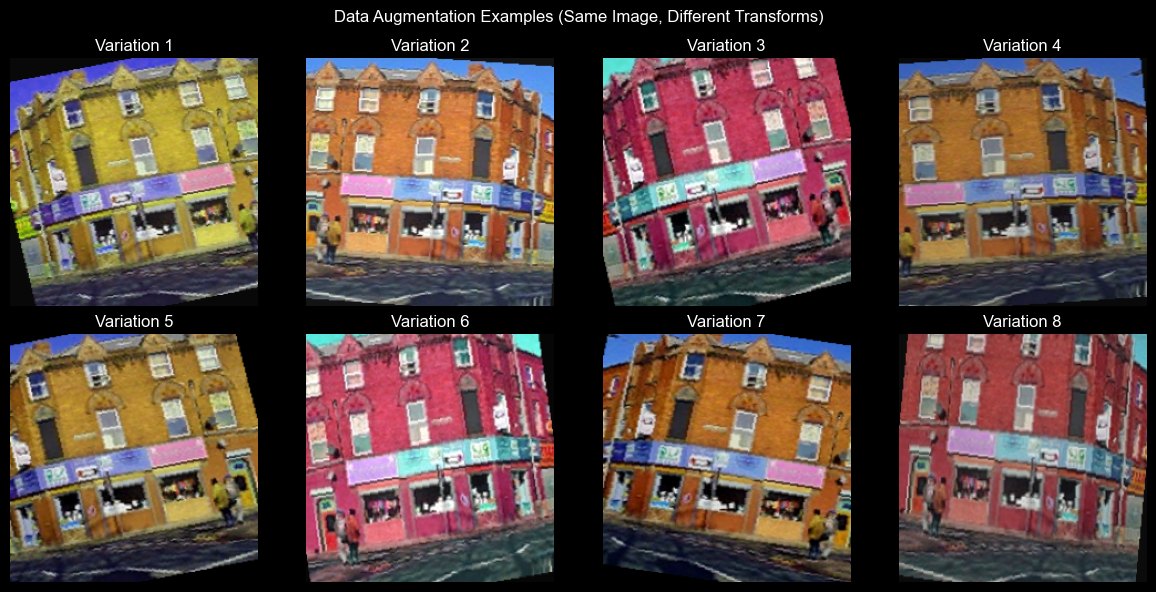

Each image shows a different random augmentation applied to the same source image.


In [8]:
def show_augmentations(dataset, num_samples=8):
    """Show different augmentations of the same image."""
    img_path = dataset.image_paths[0]

    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.flatten()

    for i in range(num_samples):
        # Load and transform (different each time due to randomness)
        img = Image.open(img_path).convert('RGB')
        img_tensor = dataset.transform(img)

        # Denormalize for display
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img_display = torch.clamp(img_tensor * std + mean, 0, 1)

        axes[i].imshow(img_display.permute(1, 2, 0))
        axes[i].axis('off')
        axes[i].set_title(f'Variation {i+1}')

    plt.suptitle('Data Augmentation Examples (Same Image, Different Transforms)', fontsize=12)
    plt.tight_layout()
    plt.show()

print("\n=== AUGMENTATION EXAMPLES ===\n")
show_augmentations(train_dataset)
print("Each image shows a different random augmentation applied to the same source image.")

## BASELINE MODEL (WITH PERFORMANCE ANALYSIS)

**BASELINE MODEL: ResNet-50 with Transfer Learning**

### Transfer Learning Strategy

**Architecture & Pretrained Weights**
- Model: ResNet-50 pretrained on ImageNet
- Initial weights: ImageNet-trained (already contain learned features for natural images)

**Fine-tuning Approach: Selective Layer Unfreezing**

We use a **progressive unfreezing** strategy:
1. **Freeze** early layers (layer1, layer2) - these learn low-level features (edges, textures) that generalize well from ImageNet
2. **Unfreeze** later layers (layer3, layer4) - these learn scene-specific high-level features
3. **Replace** final classification head: Remove ImageNet's 1000-class layer, add new 6-class head for our scenes
4. **Different learning rates**: Lower LR for unfrozen backbone (1e-4), higher LR for new head (1e-3)

**Why this strategy?**
- ImageNet features are directly relevant (both are natural images)
- Early layers don't need retraining (saves computation, prevents overfitting)
- Later layers need fine-tuning (scene classification is different from object classification)
- Different LRs prevent destroying learned features while allowing adaptation

### Baseline Hyperparameters (Default Settings)
- Learning rate (backbone): 1e-4
- Learning rate (classification head): 1e-3
- Batch size: 32
- Epochs: 10
- Optimizer: Adam (adaptive learning, less sensitive to LR choice)
- Loss function: CrossEntropyLoss (standard for multi-class classification)
- No learning rate schedule (constant LR for clean comparison)

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from PIL import Image

np.random.seed(42)
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

class ResNet50FineTuned(nn.Module):
    def __init__(self, num_classes=6, freeze_backbone_early=True):
        super().__init__()
        self.model = models.resnet50(pretrained=True)

        if freeze_backbone_early:
            for param in self.model.layer1.parameters():
                param.requires_grad = False
            for param in self.model.layer2.parameters():
                param.requires_grad = False

        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)

    def get_optimizer(self, lr_backbone=1e-4, lr_head=1e-3, weight_decay=1e-5):
        backbone_params = []
        head_params = []

        for name, param in self.model.named_parameters():
            if 'fc' not in name and param.requires_grad:
                backbone_params.append(param)
            elif 'fc' in name:
                head_params.append(param)

        param_groups = [
            {'params': backbone_params, 'lr': lr_backbone},
            {'params': head_params, 'lr': lr_head}
        ]

        return optim.Adam(param_groups, weight_decay=weight_decay)

print("Model class defined")

def train_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    return total_loss / total_samples, total_correct / total_samples

def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss, total_correct, total_samples = 0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    return total_loss / total_samples, total_correct / total_samples

def test_model(model, test_loader, device):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

print("Training functions defined")

### Google Colab

For efficiency reasons, the next part of the code needs to be run in Google Colab. That is why it is explicitly in a markdown file. Afterward, there will be a folder 'saved_models', this needs to be copied over back to the local coding structure under the root. As it is run in a different environment, some code from the previous cells (like loading data and preprocessing) needs to be copied over as well.

**Note for the teammates:** Since Google Colab can be synced with Google Drive folder, I've created one we are sharing and the file for running training model is already there. If in doubt which code is absolutely necessary to copy to Google Colab, open the training file.

```
print("\n" + "="*70)
print("TRAINING: BASELINE - ResNet-50 (Default LR)")
print("="*70 + "\n")

model = ResNet50FineTuned(num_classes=6, freeze_backbone_early=True)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = model.get_optimizer(lr_backbone=1e-4, lr_head=1e-3)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
baseline_model_dir = os.path.join(f'{project_dir}/saved_models', f'baseline_resnet50_{timestamp}')
os.makedirs(baseline_model_dir, exist_ok=True)
os.makedirs(os.path.join(baseline_model_dir, 'logs'), exist_ok=True)

writer = SummaryWriter(os.path.join(baseline_model_dir, 'logs'))

num_epochs = 10
best_val_accuracy = 0
best_model_state = None
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/val', val_loss, epoch)
    writer.add_scalar('Accuracy/train', train_acc, epoch)
    writer.add_scalar('Accuracy/val', val_acc, epoch)

    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        best_model_state = model.state_dict().copy()

    print(f"Epoch {epoch+1:2d}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

writer.close()

# Save model
model.load_state_dict(best_model_state)
torch.save(best_model_state, os.path.join(baseline_model_dir, 'best_model.pt'))

checkpoint_data = {
    'epoch': num_epochs,
    'model_state_dict': best_model_state,
    'history': history,
    'config': {
        'model': 'ResNet-50',
        'lr_backbone': 1e-4,
        'lr_head': 1e-3,
        'batch_size': 32,
        'num_epochs': num_epochs,
        'freeze_strategy': 'early layers (layer1, layer2) frozen'
    }
}

torch.save(checkpoint_data, os.path.join(baseline_model_dir, 'checkpoint.pt'))

print(f"\nBaseline model saved to: {baseline_model_dir}")
```

**EVALUATION**

The trained model as well as training history need to be loaded into the notebook. As the training was done in Google Colab on GPU and this notebook works on CPU, the checkpoint.pt needs to be explicitly mapped.

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load checkpoint
baseline_dir = 'saved_models/baseline_resnet50_20251210_220802'
checkpoint = torch.load(
    os.path.join(baseline_dir, "checkpoint.pt"),
    map_location=torch.device("cpu")
)

# Extract training history
history = checkpoint['history']
config = checkpoint['config']

print("=== BASELINE MODEL CONFIGURATION ===\n")
for key, value in config.items():
    print(f"{key}: {value}")

=== BASELINE MODEL CONFIGURATION ===

model: ResNet-50
lr_backbone: 0.0001
lr_head: 0.001
batch_size: 32
num_epochs: 10
freeze_strategy: early layers (layer1, layer2) frozen


We plot the loss and accuracy curves for both the training and validation sets across all epochs. These charts help us understand how well the model learned over time, revealing patterns like steady improvement, overfitting, or underfitting.

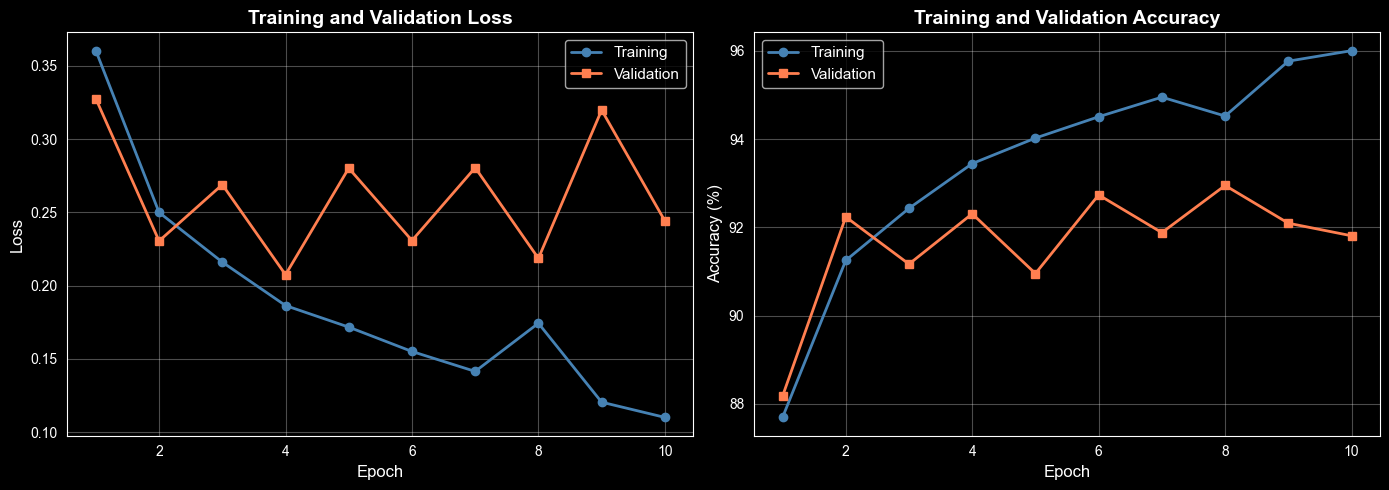


Final Training Accuracy: 96.00%
Final Validation Accuracy: 91.81%
Best Validation Accuracy: 92.95%


In [11]:
num_epochs = len(history['train_loss'])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
axes[0].plot(range(1, num_epochs+1), history['train_loss'], 'o-',
             label='Training', linewidth=2, markersize=6, color='steelblue')
axes[0].plot(range(1, num_epochs+1), history['val_loss'], 's-',
             label='Validation', linewidth=2, markersize=6, color='coral')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, weight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Accuracy curves
axes[1].plot(range(1, num_epochs+1), [acc*100 for acc in history['train_acc']], 'o-',
             label='Training', linewidth=2, markersize=6, color='steelblue')
axes[1].plot(range(1, num_epochs+1), [acc*100 for acc in history['val_acc']], 's-',
             label='Validation', linewidth=2, markersize=6, color='coral')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, weight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal Training Accuracy: {history['train_acc'][-1]*100:.2f}%")
print(f"Final Validation Accuracy: {history['val_acc'][-1]*100:.2f}%")
print(f"Best Validation Accuracy: {max(history['val_acc'])*100:.2f}%")

**Evaluate the model using test data**

Now we load our best-performing model and use it to make predictions on the test set. This final evaluation gives us an unbiased estimate of how well the model is likely to perform on new, unseen data.

In [12]:
model = ResNet50FineTuned(num_classes=6, freeze_backbone_early=True)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

# Get predictions on test set
print("\n=== EVALUATING ON TEST SET ===\n")
test_preds, test_labels = test_model(model, test_loader, device)

# Calculate test accuracy
test_accuracy = 100 * (test_preds == test_labels).sum() / len(test_labels)
print(f"Test Accuracy: {test_accuracy:.2f}%")

C:\Users\dobis\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\dobis\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



=== EVALUATING ON TEST SET ===

Test Accuracy: 92.77%


We break down the model’s accuracy for each scene category to see how well it performs across different classes. This detailed view highlights which categories are easiest or most challenging for the model, helping us identify any weaknesses or potential sources of confusion.


=== PER-CLASS ACCURACY ===

Buildings   : 95.19% (416/437 correct)
Forest      : 99.37% (471/474 correct)
Glacier     : 80.65% (446/553 correct)
Mountain    : 93.90% (493/525 correct)
Sea         : 96.86% (494/510 correct)
Street      : 92.42% (463/501 correct)


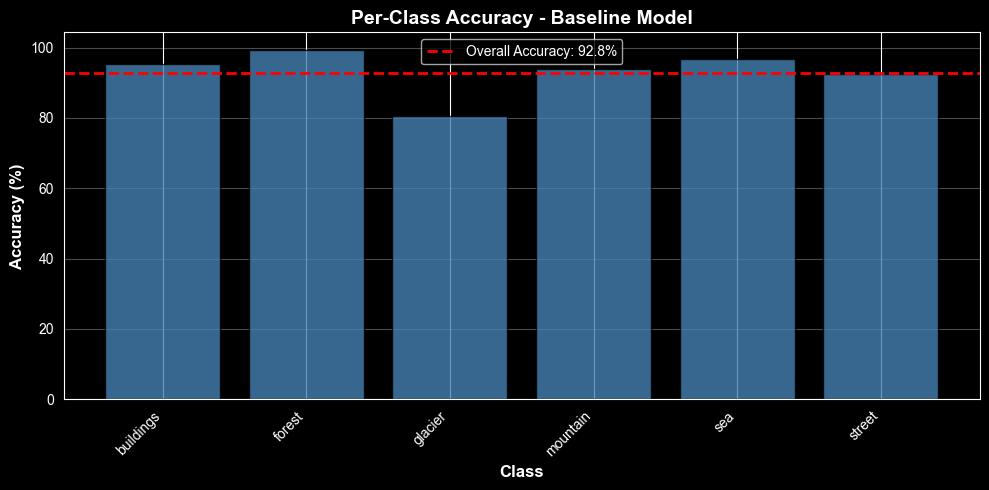

In [13]:
print("\n=== PER-CLASS ACCURACY ===\n")
for i, class_name in enumerate(class_names):
    class_mask = test_labels == i
    class_total = class_mask.sum()
    class_correct = ((test_preds == i) & class_mask).sum()
    class_acc = 100 * class_correct / class_total if class_total > 0 else 0

    print(f"{class_name.capitalize():12s}: {class_acc:5.2f}% ({class_correct}/{class_total} correct)")

# Visualize per-class accuracy
per_class_acc = []
for i in range(len(class_names)):
    class_mask = test_labels == i
    class_total = class_mask.sum()
    class_correct = ((test_preds == i) & class_mask).sum()
    class_acc = 100 * class_correct / class_total if class_total > 0 else 0
    per_class_acc.append(class_acc)

plt.figure(figsize=(10, 5))
bars = plt.bar(class_names, per_class_acc, color='steelblue', alpha=0.8, edgecolor='black')
plt.axhline(y=test_accuracy, color='red', linestyle='--', linewidth=2,
            label=f'Overall Accuracy: {test_accuracy:.1f}%')
plt.xlabel('Class', fontsize=12, weight='bold')
plt.ylabel('Accuracy (%)', fontsize=12, weight='bold')
plt.title('Per-Class Accuracy - Baseline Model', fontsize=14, weight='bold')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

**Classification Report**

In [14]:
print("\n=== DETAILED CLASSIFICATION REPORT ===\n")
report = classification_report(test_labels, test_preds,
                               target_names=class_names,
                               digits=3)
print(report)


=== DETAILED CLASSIFICATION REPORT ===

              precision    recall  f1-score   support

   buildings      0.914     0.952     0.933       437
      forest      0.987     0.994     0.991       474
     glacier      0.931     0.807     0.864       553
    mountain      0.833     0.939     0.883       525
         sea      0.965     0.969     0.967       510
      street      0.955     0.924     0.939       501

    accuracy                          0.928      3000
   macro avg      0.931     0.931     0.929      3000
weighted avg      0.930     0.928     0.927      3000



**Confusion Matrix**

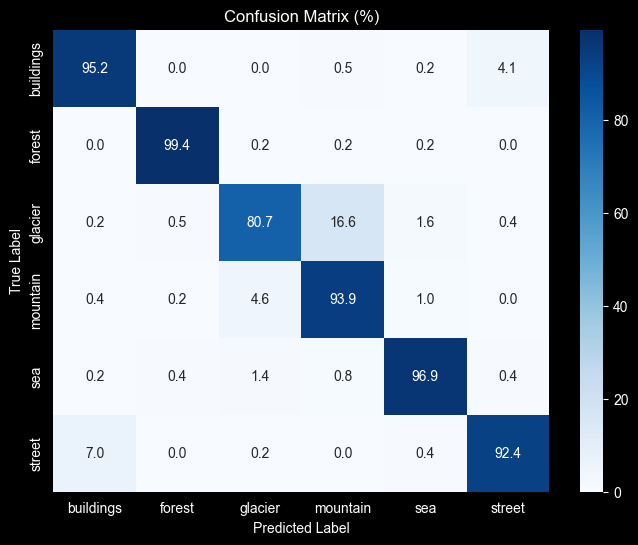

In [15]:
cm = confusion_matrix(test_labels, test_preds)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (%)')
plt.show()

## HYPERPARAMETER EXPERIMENTS (WITH PERFORMANCE ANALYSIS)

## SCRATCH CNN (WITH PERFORMANCE ANALYSIS)

## GRAD-CAM AND ERROR ANALYSIS

## FINAL COMPARISON BETWEEN MODELS

## CONCLUSIONS AND FUTURE WORK